In [1]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split, ConcatDataset
import os
import json
import pickle
from typing import List
from torchmetrics.text import CharErrorRate, WordErrorRate

activate_ViT = json.load(open('config.json'))["Encoder"]["ViT"]
config = json.load(open('config.json'))["fine-tuning"]
ssl_config = json.load(open('config.json'))["SSL"]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from custom_dataset import DecoderDataset
from encoder import Encoder
from ViT_encoder import ViTEncoder
from Decoder import LSTMAttnDecoder

with open(config["char to token"], 'rb') as f:
    char_to_token = pickle.load(f)

In [3]:
with open(config["token to char"], "rb") as f:
    token_to_char = pickle.load(f)

def tokenizer_func(input_list: List[torch.tensor]) -> List[str]:
    output = [token_to_char[index.item()] for index in input_list]
    output = "".join(output)
    output = output.split("<PAD>")[0]
    output = output.split("<EOS>")[0]
    return output

In [4]:
torch.manual_seed(0)
if activate_ViT:
	encoder = ViTEncoder(input_size=(64, 384), patch_size=16, hidden_dim=516, num_heads=3, num_layers=12).to(device)
	decoder = LSTMAttnDecoder(258, len(token_to_char)).to(device)
else:
	encoder = Encoder().to(device)
	decoder = LSTMAttnDecoder(256, len(token_to_char)).to(device)
if config["fine-tune on other dataset"]:
	print("fine-tuning on other dataset")
	print("load", config["Encoder path for fine-tuning"])
	encoder.load_state_dict(torch.load(config["Encoder path for fine-tuning"]))
	print("load", config["Decoder path for fine-tuning"])
	decoder.load_state_dict(torch.load(config["Decoder path for fine-tuning"]))
else:
	print("not fine-tuning on other dataset")
	print("load", ssl_config["saved Encoder path"])
	# encoder.load_state_dict(torch.load(ssl_config["saved Encoder path"]))

if config["Freeze Encoder"]:
	print("Freezing Encoder")
	for param in encoder.parameters():
		param.requires_grad = False

fine-tuning on other dataset
load models/trdg_Encoder_9_13.pt
load models/trdg_Decoder_9_13.pt


In [5]:
torch.manual_seed(0)
decoder_dataset = []
for i in range(1, 4):
	if config[f"dataset {i}"] is not None and config[f"dataset {i} csv"] is not None:
		decoder_dataset.append(DecoderDataset(config[f"dataset {i} csv"], config[f"dataset {i}"], char_to_token))
decoder_dataset = ConcatDataset(decoder_dataset)
train_size = int(0.9 * len(decoder_dataset))
val_size = len(decoder_dataset) - train_size
train_dataset, val_dataset = random_split(decoder_dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=config["Batch size"], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config["Batch size"], shuffle=False)

In [6]:
criterion = CrossEntropyLoss()
optimizer = Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=config["start lr"])
scheduler = StepLR(optimizer, step_size=config["lr scheduler step size"], gamma=0.1)
cer = CharErrorRate()
wer = WordErrorRate()

In [7]:
torch.manual_seed(0)

epochs = config["epoch size"]
SOS_token = char_to_token['<SOS>']
train_cer_list = []
train_steps = []
step = 0
val_cer_list = []
val_steps = []

for epoch in range(epochs):
    # Training loop
    decoder.train()
    total_cer = 0
    for i, (imgs, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        imgs, labels = imgs.to(device), labels.to(device)

        encoder_outputs, decoder_hidden = encoder(imgs)  # Encoder's forward pass
        decoder_input = torch.tensor([[SOS_token]] * labels.size(0)).to(device)  # SOS token

        loss = 0
        predictions = []
        for t in range(labels.size(1)):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, decoder_output_labels = torch.max(decoder_output, dim=1)

            loss += criterion(decoder_output, labels[:, t])
            predictions.append(decoder_output_labels.unsqueeze(0))

            decoder_input = labels[:, t].unsqueeze(1)  # Teacher forcing
        loss.backward()
        optimizer.step()
        step += 1

        if i % 100 == 0:
            predictions = torch.cat(predictions).transpose(0, 1)
            decoded_predictions = [tokenizer_func(pred.view(-1)) for pred in predictions]
            decoded_labels = [tokenizer_func(label.view(-1)) for label in labels]
            batch_cer = cer(preds=decoded_predictions, target=decoded_labels)
            
            print(
                f"Epoch {epoch + 1}/{epochs}, Batch {i}/{len(train_dataloader)}, Loss: {loss.item()}, CER: {batch_cer}, LR: {scheduler.get_last_lr()[0]}")
            train_cer_list.append(batch_cer)
            train_steps.append(step)
    scheduler.step()

    # Validation loop
    decoder.eval()
    with torch.no_grad():  # Disable gradient calculation
        total_val_loss = 0
        total_val_cer = 0
        total_val_wer = 0
        val_batch_count = 0
        for i, (imgs, labels) in enumerate(val_dataloader):
            imgs, labels = imgs.to(device), labels.to(device)
            encoder_outputs, decoder_hidden = encoder(imgs)
            decoder_input = torch.tensor([[SOS_token]] * labels.size(0)).to(device)

            loss = 0
            val_predictions = []
            for t in range(labels.size(1)):
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
                _, decoder_output_labels = torch.max(decoder_output, dim=1)

                loss += criterion(decoder_output, labels[:, t])
                val_predictions.append(decoder_output_labels.unsqueeze(0))

                decoder_input = labels[:, t].unsqueeze(1)  # Teacher forcing

            total_val_loss += loss.item()
            # Transpose and calculate CER
            val_predictions = torch.cat(val_predictions).transpose(0, 1)
            decoded_predictions = [tokenizer_func(pred.view(-1)) for pred in val_predictions]
            decoded_labels = [tokenizer_func(label.view(-1)) for label in labels]
            total_val_cer += cer(preds=decoded_predictions, target=decoded_labels)
            total_val_wer += wer(" ".join(decoded_predictions), " ".join(decoded_labels))

        val_loss = total_val_loss / len(val_dataloader)
        val_cer = total_val_cer / len(val_dataloader)
        val_wer = total_val_wer / len(val_dataloader)
        val_cer_list.append(val_cer)
        val_steps.append(step)

    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation CER: {val_cer}, Validation WER: {val_wer}, LR: {scheduler.get_last_lr()[0]}")

Epoch 1/30, Batch 0/161, Loss: 33.351318359375, CER: 0.9554139971733093, LR: 0.0001
Epoch 1/30, Batch 100/161, Loss: 3.574328899383545, CER: 0.13684210181236267, LR: 0.0001
Epoch 1/30, Validation Loss: 2.139467590385013, Validation CER: 0.09670870006084442, Validation WER: 0.32458335161209106, LR: 0.0001
Epoch 2/30, Batch 0/161, Loss: 3.175828218460083, CER: 0.13793103396892548, LR: 0.0001
Epoch 2/30, Batch 100/161, Loss: 2.1431238651275635, CER: 0.0904255285859108, LR: 0.0001
Epoch 2/30, Validation Loss: 1.9812654124365912, Validation CER: 0.08811932802200317, Validation WER: 0.2997916638851166, LR: 0.0001
Epoch 3/30, Batch 0/161, Loss: 2.3066134452819824, CER: 0.09815950691699982, LR: 0.0001
Epoch 3/30, Batch 100/161, Loss: 1.6618186235427856, CER: 0.06976744532585144, LR: 0.0001
Epoch 3/30, Validation Loss: 1.2394919527901544, Validation CER: 0.05707933008670807, Validation WER: 0.22812499105930328, LR: 0.0001
Epoch 4/30, Batch 0/161, Loss: 1.61664879322052, CER: 0.0892857164144516,

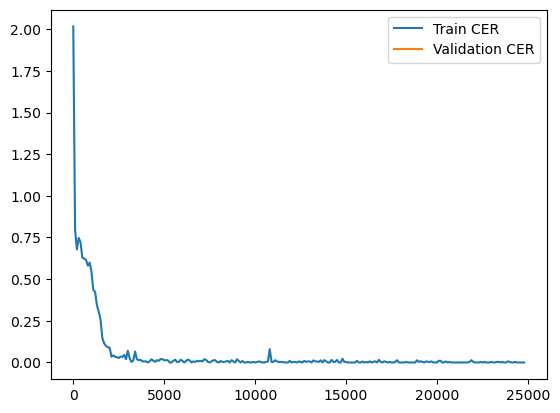

In [8]:
from matplotlib import pyplot as plt

plt.plot(train_steps, train_cer_list, label='Train CER')
plt.plot(val_steps, val_cer_list, label='Validation CER')
plt.legend()
plt.show()

In [9]:
import pickle

with open("val_cer_without_SSL.pkl", "wb") as f:
	pickle.dump(val_cer_list, f)

with open("steps.pkl", "wb") as f:
	pickle.dump(val_steps, f)

In [9]:
torch.save(encoder.state_dict(), config["saved Encoder path"])
torch.save(decoder.state_dict(), config["saved Decoder path"])

In [10]:
import pickle
import torch
from encoder import Encoder
from Decoder import LSTMAttnDecoder
import os
import json
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Lambda, Grayscale

activate_ViT = json.load(open('config.json'))["Encoder"]["ViT"]
config = json.load(open('config.json'))["fine-tuning"]
ssl_config = json.load(open('config.json'))["SSL"]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
with open(config["token to char"], "rb") as f:
    token_to_char = pickle.load(f)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if activate_ViT:
    encoder = ViTEncoder(input_size=(64, 384), patch_size=16, hidden_dim=516, num_heads=3, num_layers=12).to(device)
    decoder = LSTMAttnDecoder(258, len(token_to_char)).to(device)
else:
    encoder = Encoder().to(device)
    decoder = LSTMAttnDecoder(256, len(token_to_char)).to(device)
encoder.load_state_dict(torch.load(config["saved Encoder path"]))
decoder.load_state_dict(torch.load(config["saved Decoder path"]))

<All keys matched successfully>

In [12]:
with open(config["char to token"], 'rb') as f:
    char_to_token = pickle.load(f)

SOS_token = char_to_token['<SOS>']
test_dataset_folder = config["test dataset"]

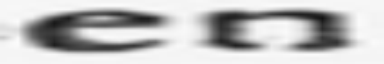

['n', 'j', 'e', 'o', 'n', 't', 's', 'i', 'b', '<EOS>']


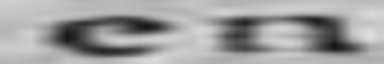

['a', 'i', 'q', 'u', 'i', 't', 'b', 'a', '<EOS>']


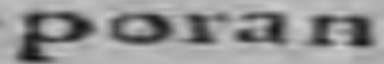

['y', 'e', 'a', 'n', 'i', 'l', 'i', 't', '<EOS>']


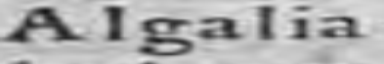

['i', 'e', 't', 'i', 'g', 'a', 'b', 'l', 'i', 's', '<EOS>']


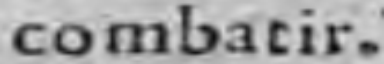

['e', 'o', 'f', 'h', 'u', 'a', 't', 'i', 'r', 's', '<EOS>']


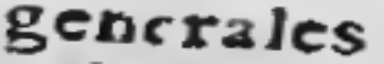

['y', 'v', 'o', 't', 'i', 'a', 'l', 'c', 'e', '<EOS>']


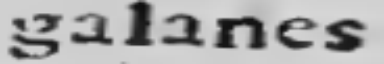

['a', 's', 't', 'b', 's', 'l', 'r', 'e', 'c', 'e', '<EOS>']


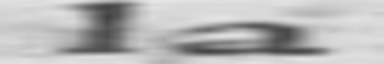

['a', 'b', 't', 'c', 'e', 'l', 'l', '<EOS>']


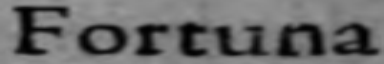

['f', 'o', 'r', 't', 'u', 'n', 'a', '<EOS>']


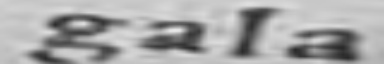

['s', 'e', 'v', 'a', 't', 'r', 'a', '<EOS>']


In [13]:
import PIL
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms import ToPILImage

import random

img_size = (64, 384)

data_transform = transforms.Compose([
            Lambda(lambda img: img.convert("RGB")),
            Grayscale(num_output_channels=3),
            Resize(img_size),
            ToTensor(),  # Convert image to PyTorch Tensor in CHW format
        ])

decoder.eval()

test_data_files = os.listdir(test_dataset_folder)
random.shuffle(test_data_files)

with torch.no_grad():
    for filename in test_data_files[:10]:
        image = Image.open(os.path.join(test_dataset_folder, filename))
        image = data_transform(image)
        display(ToPILImage()(image))
        image_tensor = image.unsqueeze(0).to(device)
        encoder_outputs, decoder_hidden = encoder(image_tensor)
        decoder_input = torch.tensor([[SOS_token]] * image_tensor.size(0)).to(device)
        prediction = []
        for t in range(20):  # Assuming maximum sequence length is 50
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, topi = decoder_output.topk(1)
            decoder_input = topi.detach()
            prediction.append(decoder_input.item())
            if decoder_input.item() == char_to_token['<EOS>']:
                break
        print([token_to_char[i] for i in prediction])